In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import PIL
from itertools import combinations
from math import atan
from sklearn.cluster import KMeans

In [2]:
masks = context.catalog.load("masks_batched")

[05/28/23 19:32:44] INFO     Loading data from 'masks_batched' (PartitionedDataSet)...          ]8;id=289186;file:///home/zig/.pyenv/versions/3.10.8/envs/sibigrapi23/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=612794;file:///home/zig/.pyenv/versions/3.10.8/envs/sibigrapi23/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [3]:
images = context.catalog.load("express_expense")

                    INFO     Loading data from 'express_expense' (PartitionedDataSet)...        ]8;id=631244;file:///home/zig/.pyenv/versions/3.10.8/envs/sibigrapi23/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=858391;file:///home/zig/.pyenv/versions/3.10.8/envs/sibigrapi23/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [4]:
def edge_detect(image):
    # edge detection
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(image, (5, 5), 0)
    edged = cv2.Canny(gray, 75, 200)
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # bounding convex polygon
    cnt = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)
    chosen_contours = cnt[0]
    for i in range(1, min(len(cnt), 4)):
        np.concatenate([chosen_contours, contours[i]], axis=0)
    hull = np.intp(cv2.convexHull(chosen_contours))
    # # bounding rect with perspective
    epsilon = 0.001 * cv2.arcLength(hull, True)
    points = cv2.approxPolyDP(hull, epsilon, True)
    return hull

def mask_to_image(mask):
    return mask.astype(np.uint8) * 255

In [5]:
# dilate mask?
# area > 0.35
# similarity to square??
# highest IOU

In [58]:
img_number = 1189

In [59]:
m1 = masks[f'batched_{img_number}']()

In [60]:
list(m1.keys())

['masks', 'iou_predictions']

In [61]:
m1['iou_predictions']

array([[0.619761  , 1.0030487 , 0.98546624]], dtype=float32)

In [62]:
m1['masks']

array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, Fa

In [63]:
im1 = np.array(images[f'{img_number}-receipt.jpg']())

In [64]:
im1.shape

(450, 338, 3)

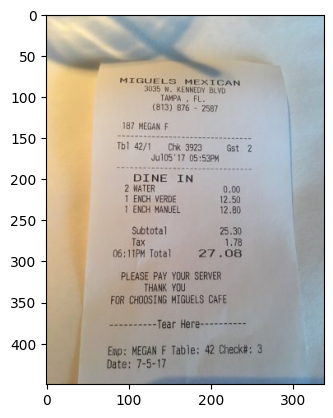

In [65]:
plt.imshow(im1)

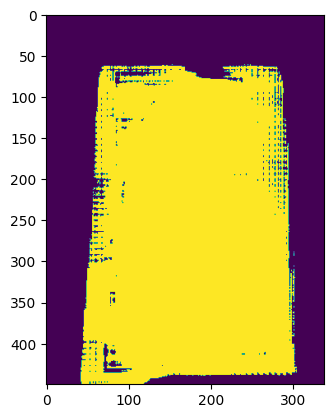

In [66]:
plt.imshow(m1['masks'][0][0])

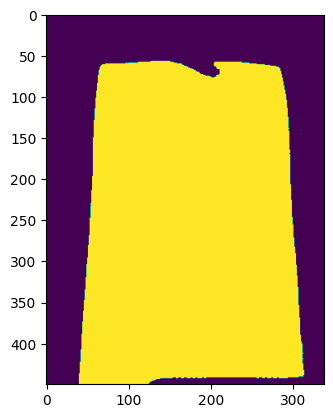

In [67]:
plt.imshow(m1['masks'][0][1])

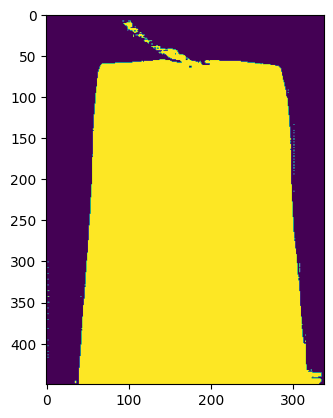

In [68]:
plt.imshow(m1['masks'][0][2])

In [69]:
border_size = 10
chosen_mask = 1
img_canny = cv2.Canny(cv2.copyMakeBorder(mask_to_image(m1['masks'][0][chosen_mask]), border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, 0), 75, 200).astype(np.uint8)

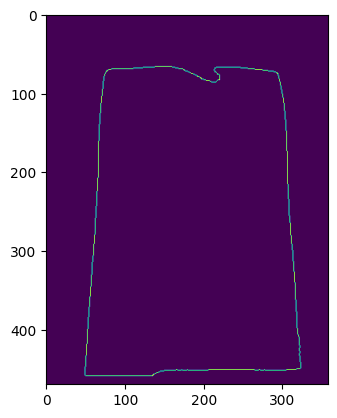

In [70]:
plt.imshow(img_canny)

(18, 1, 2)


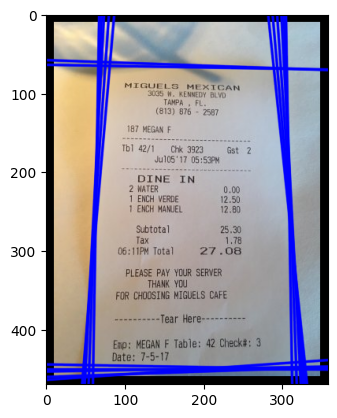

In [87]:
lines = cv2.HoughLines(img_canny, 3, np.pi / 180, 90)
print(lines.shape)

img_hough = cv2.copyMakeBorder(im1, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, 0)
#img_hough = im1#cv2.cvtColor(img_canny, cv2.COLOR_GRAY2BGR)
if lines is not None:
    for rho, theta in lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img_hough, (x1, y1), (x2, y2), (0, 0, 255), 2, cv2.LINE_AA)
        
plt.imshow(img_hough)

In [72]:
def get_angle_between_lines(line_1, line_2):
    rho1, theta1 = line_1
    rho2, theta2 = line_2
    # x * cos(theta) + y * sin(theta) = rho
    # y * sin(theta) = x * (- cos(theta)) + rho
    # y = x * (-cos(theta) / sin(theta)) + rho
    m1 = -(np.cos(theta1) / np.sin(theta1))
    m2 = -(np.cos(theta2) / np.sin(theta2))
    return abs(atan(abs(m2-m1) / (1 + m2 * m1))) * (180 / np.pi)

def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.
    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1
    rho2, theta2 = line2

    A = np.array([
      [np.cos(theta1), np.sin(theta1)],
      [np.cos(theta2), np.sin(theta2)]
    ])

    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]

In [73]:
intersections = []
group_lines = combinations(range(len(lines)), 2)
x_in_range = lambda x: 0 <= x <= img_hough.shape[1]
y_in_range = lambda y: 0 <= y <= img_hough.shape[0]

for i, j in group_lines:
  line_i, line_j = lines[i][0], lines[j][0]

  if 60.0 < get_angle_between_lines(line_i, line_j) < 120.0:
      int_point = intersection(line_i, line_j)

      if x_in_range(int_point[0][0]) and y_in_range(int_point[0][1]): 
          intersections.append(int_point)

In [74]:
intersections

[[[47, 454]],
 [[323, 449]],
 [[51, 454]],
 [[321, 449]],
 [[55, 454]],
 [[46, 454]],
 [[325, 449]]]

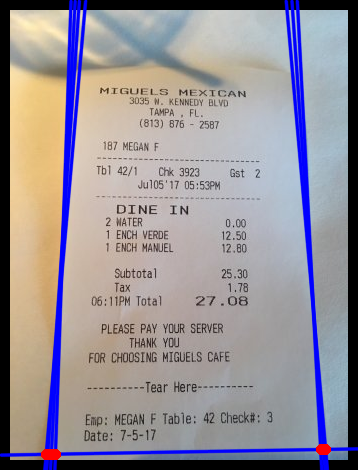

In [75]:
for point in np.array(intersections)[:, 0]:
    cv2.circle(img_hough, point, 3, (255, 0, 0), 3).astype('uint8')
    
PIL.Image.fromarray(img_hough)

In [47]:
model = KMeans(n_clusters=4, n_init='auto', random_state=42)

In [48]:
X = np.array(intersections)[:, 0]

In [49]:
X.shape

(72, 2)

In [50]:
model.fit(X)

KMeans(n_clusters=4, n_init='auto', random_state=42)

In [51]:
#points = [[center.tolist()] for center in model.cluster_centers_]

In [52]:
points = np.rint(model.cluster_centers_).astype(np.int32)
points = np.clip(points - border_size, 0, max(*im1.shape))

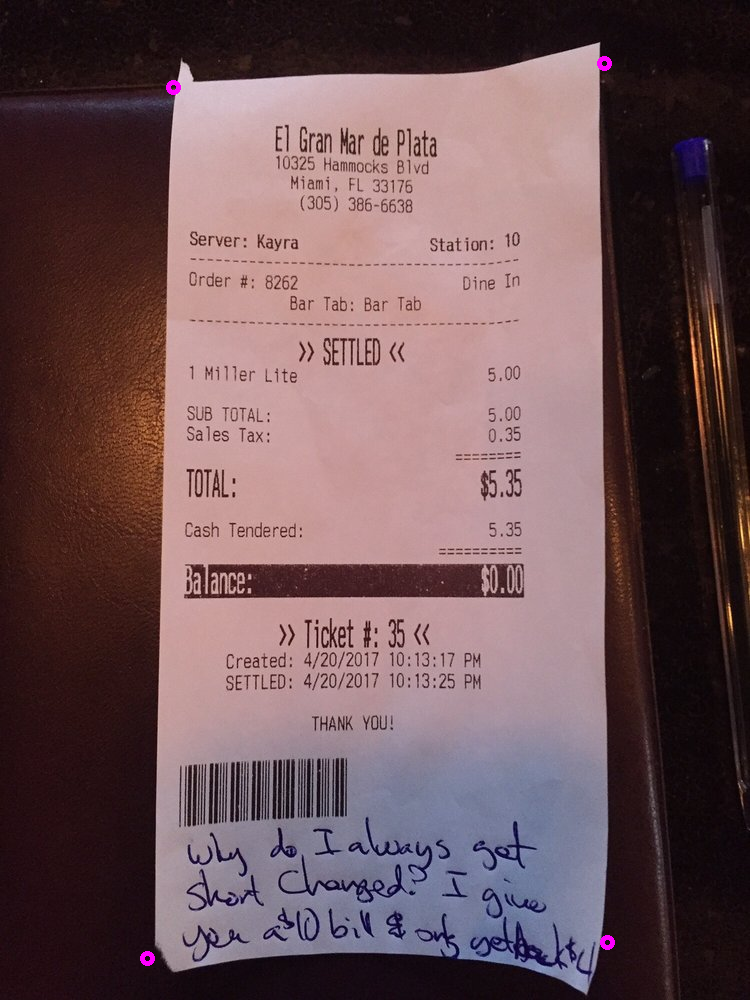

In [53]:
final_points_image = np.array(im1)

for point in points:
    cv2.circle(final_points_image, point, 5, (255, 0, 255), 3).astype('uint8')

PIL.Image.fromarray(final_points_image)

In [54]:
points

array([[607, 942],
       [604,  63],
       [173,  87],
       [147, 958]], dtype=int32)

In [55]:
np.rint(np.array(cv2.minAreaRect(points)[:2]).reshape(-1)).astype(np.int32)

array([376, 510, 893, 460], dtype=int32)

In [56]:
gray = cv2.cvtColor(np.array(im1), cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# bounding convex polygon
cnt = sorted(contours, key=lambda c: cv2.arcLength(c, True), reverse=True)
chosen_contours = cnt[0]
for i in range(1, min(len(cnt), 4)):
    chosen_contours = np.concatenate([chosen_contours, cnt[i]], axis=0)
hull = np.intp(cv2.convexHull(np.concatenate(chosen_contours, axis=0)))

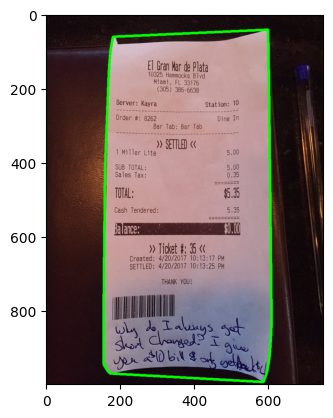

In [57]:
plt.imshow(cv2.drawContours(im1.copy(), [hull], -1, (0,255,0), 5))